In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

random_state = 42

In [2]:
def read_dataset(path, sep=';', encoding='utf-8-sig', low_memory=False):
    return pd.read_csv(path, sep=sep, encoding=encoding, low_memory=low_memory)

subjects_bak_spec = read_dataset("../../../../../data/datasets/filtered/subjects_bak_spec_filtered_lof.csv")
subjects_magistr = read_dataset("../../../../../data/datasets/filtered/subjects_magistr_filtered_lof.csv")

In [3]:
X_s_bak_spec = subjects_bak_spec.drop(columns=["Таргет"])
y_s_bak_spec = subjects_bak_spec["Таргет"]

X_train_s_bak_spec, X_test_s_bak_spec, y_train_s_bak_spec, y_test_s_bak_spec = train_test_split(
    X_s_bak_spec,
    y_s_bak_spec,
    test_size=0.2,
    random_state=random_state
)

X_s_magistr = subjects_magistr.drop(columns=["Таргет"])
y_s_magistr = subjects_magistr["Таргет"]

X_train_s_magistr, X_test_s_magistr, y_train_s_magistr, y_test_s_magistr = train_test_split(
    X_s_magistr,
    y_s_magistr,
    test_size=0.2,
    random_state=random_state
)

Лучший порог: 0.556, F1.5 для класса 1: 0.748
{'clf__C': 10, 'clf__class_weight': 'balanced', 'kernel__gamma': 0.001, 'kernel__n_components': 50}
Лучшая модель: Pipeline(steps=[('scaler', StandardScaler()),
                ('kernel',
                 Nystroem(gamma=0.001, n_components=50, random_state=42)),
                ('clf',
                 LogisticRegression(C=10, class_weight='balanced',
                                    max_iter=1000, random_state=42))])

Расширенный отчёт по метрикам (F1.5):
————————————————————————————————————————————————————————————
         | Precision | Recall  |  F1   |  F2   | Support
————————————————————————————————————————————————————————————
Class 1 | 0.6154    | 0.8276   | 0.7059 | 0.7482 |   29   
Class 0 | 0.9438    | 0.8485   | 0.8936 | 0.8757 |   99   
————————————————————————————————————————————————————————————
Accuracy: 0.8438
————————————————————————————————————————————————————————————


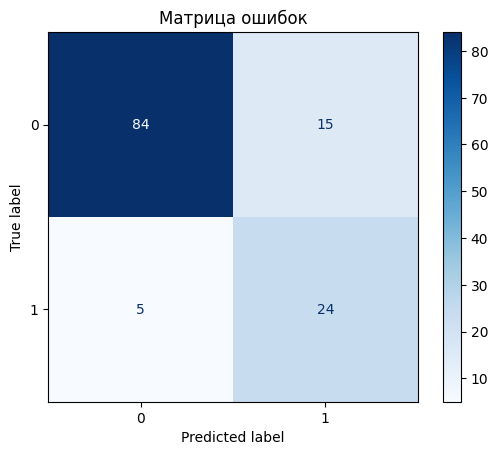


Feature Importances:
                                            feature  importance
37                      Позиция студента в рейтинге    0.277871
9                           Общее количество долгов    0.255104
10                                 fromEkaterinburg    0.030095
0                                         Приоритет    0.029852
6                                               Пол    0.024295
1                            Cумма баллов испытаний    0.020074
7                  Полных лет на момент поступления    0.019379
34                             Код направления 3: 2    0.015658
11                             fromSverdlovskRegion    0.015493
3                                          Контракт    0.011498
2                           Балл за инд. достижения    0.008126
31                            Код направления 1: 11    0.006135
36                             Код направления 3: 4    0.004741
8                         Общее количество пересдач    0.003422
32                

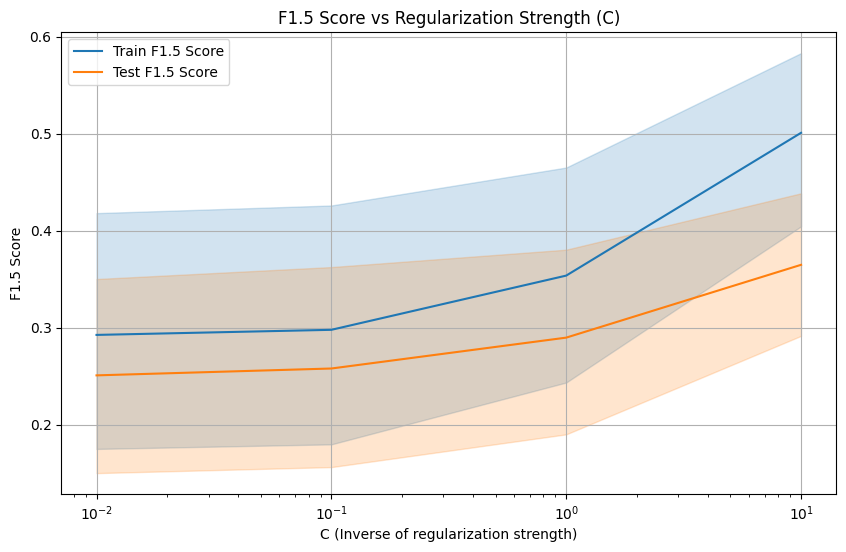

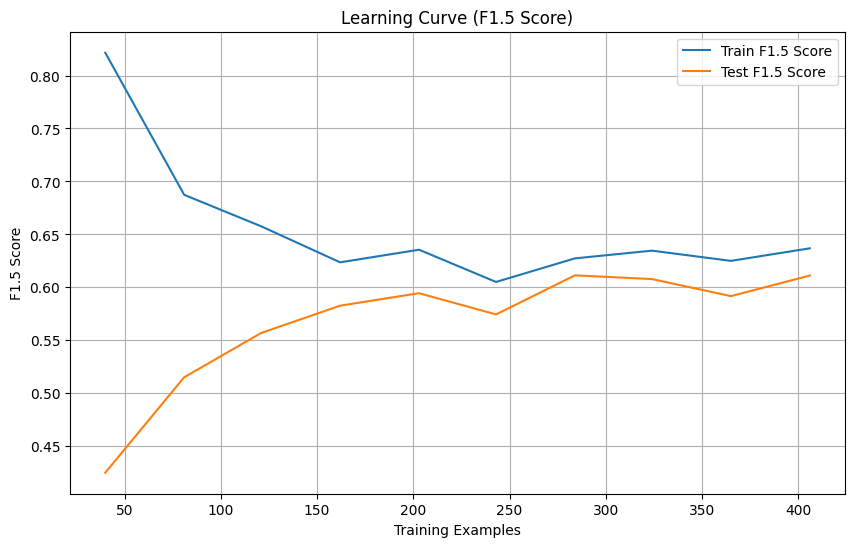

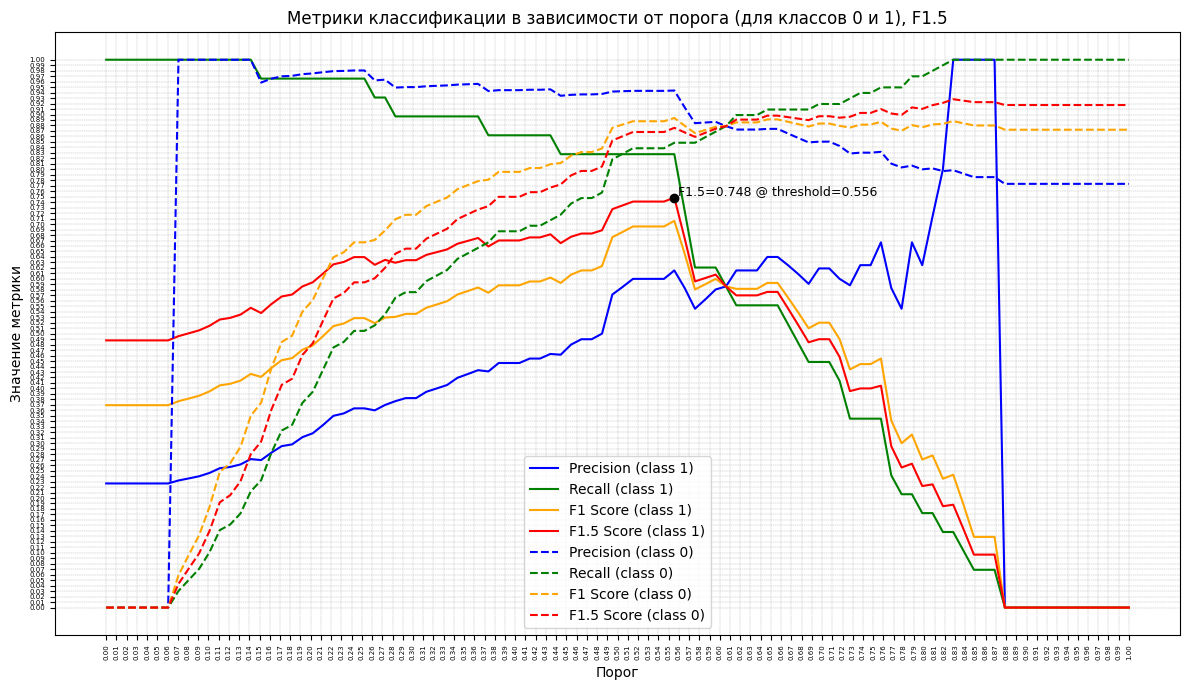

In [7]:
'''-----------------------------------------------------------------------------------------------------
                                        ИМПОРТ НЕОБХОДИМЫХ БИБЛИОТЕК
-----------------------------------------------------------------------------------------------------'''

import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, fbeta_score, make_scorer, precision_recall_fscore_support, accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.kernel_approximation import Nystroem

'''-----------------------------------------------------------------------------------------------------
                                            НАСТРОЙКИ
-----------------------------------------------------------------------------------------------------'''

BETA = 1.5

'''-----------------------------------------------------------------------------------------------------
                                            ПОДГОТОВКА ПАЙПЛАЙНА
-----------------------------------------------------------------------------------------------------'''

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kernel', Nystroem(kernel='rbf', random_state=random_state)),
    ('clf', LogisticRegression(random_state=42, max_iter=1000))
])

param_grid = {
    'kernel__n_components': [50, 100, 200],
    'kernel__gamma': [0.001, 0.01, 0.1, 1],
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__class_weight': [None, 'balanced']
}

custom_scorer = make_scorer(fbeta_score, beta=BETA, pos_label=1)

'''-----------------------------------------------------------------------------------------------------
                                                ОБУЧЕНИЕ МОДЕЛИ
-----------------------------------------------------------------------------------------------------'''

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring=custom_scorer,
    n_jobs=-1,
    return_train_score=True
)

grid_search.fit(X_train_s_magistr, y_train_s_magistr)

best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../../../../data/models/final/filtered/linear_model_nystroem_with_f_score_more_1_s_magistr_lof.joblib')

'''-----------------------------------------------------------------------------------------------------
                        ПОЛУЧЕНИЕ ЛУЧШЕГО ПОРОГА И СОЗДАНИЕ ОТЧЁТА С УЧЁТОМ ЭТОГО ПОРОГА
-----------------------------------------------------------------------------------------------------'''

y_probs = grid_search.predict_proba(X_test_s_magistr)[:, 1]

thresholds = np.linspace(0, 1, 100)
f_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)
    f = fbeta_score(y_test_s_magistr, y_pred_thresh, beta=BETA, pos_label=1)
    f_scores.append(f)

best_idx = np.argmax(f_scores)
best_threshold = thresholds[best_idx]
best_f_score = f_scores[best_idx]

print(f"Лучший порог: {best_threshold:.3f}, F{BETA} для класса 1: {best_f_score:.3f}")

y_pred_s_magistr = (y_probs >= best_threshold).astype(int)

print(grid_search.best_params_)
print("Лучшая модель:", grid_search.best_estimator_)

precision_1 = precision_score(y_test_s_magistr, y_pred_s_magistr, pos_label=1)
recall_1 = recall_score(y_test_s_magistr, y_pred_s_magistr, pos_label=1)
f1_1 = f1_score(y_test_s_magistr, y_pred_s_magistr, pos_label=1)
f2_1 = fbeta_score(y_test_s_magistr, y_pred_s_magistr, beta=BETA, pos_label=1)

precision_0 = precision_score(y_test_s_magistr, y_pred_s_magistr, pos_label=0)
recall_0 = recall_score(y_test_s_magistr, y_pred_s_magistr, pos_label=0)
f1_0 = f1_score(y_test_s_magistr, y_pred_s_magistr, pos_label=0)
f2_0 = fbeta_score(y_test_s_magistr, y_pred_s_magistr, beta=BETA, pos_label=0)

acc = accuracy_score(y_test_s_magistr, y_pred_s_magistr)

print(f"\nРасширенный отчёт по метрикам (F{BETA}):")
print("—" * 60)
print(f"{'':<8} | {'Precision':^9} | {'Recall':^7} | {'F1':^5} | {'F2':^5} | {'Support':^7}")
print("—" * 60)
print(f"Class 1 | {precision_1:.4f}    | {recall_1:.4f}   | {f1_1:.4f} | {f2_1:.4f} | {sum(y_test_s_magistr == 1):^7}")
print(f"Class 0 | {precision_0:.4f}    | {recall_0:.4f}   | {f1_0:.4f} | {f2_0:.4f} | {sum(y_test_s_magistr == 0):^7}")
print("—" * 60)
print(f"Accuracy: {acc:.4f}")
print("—" * 60)

'''-----------------------------------------------------------------------------------------------------
                                            СОЗДАНИЕ МАТРИЦЫ ОШИБОК
-----------------------------------------------------------------------------------------------------'''

cm = confusion_matrix(y_test_s_magistr, y_pred_s_magistr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.savefig('linear_model_nystroem_with_f_score_more_1/s_magistr/confusion_matrix_log_reg.png')
plt.show()

'''-----------------------------------------------------------------------------------------------------
                                          ВЫВОД ВЛИЯНИЯ ВСЕХ ПРИЗНАКОВ
-----------------------------------------------------------------------------------------------------'''

result = permutation_importance(
    best_model,
    X_test_s_magistr,
    y_test_s_magistr,
    scoring=custom_scorer,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

importances = result.importances_mean
features = X_train_s_magistr.columns

feature_importances = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

'''-----------------------------------------------------------------------------------------------------
                              ВЫВОД ЗАВИСИМОСТИ F-SCORE ОТ РЕГУЛЯРИЗАЦИИ (ПАРАМЕТР C)
-----------------------------------------------------------------------------------------------------'''

results = pd.DataFrame(grid_search.cv_results_)

results_filtered = results[[
    'param_clf__C',
    'mean_train_score',
    'mean_test_score'
]].copy()

results_filtered['param_clf__C'] = pd.to_numeric(results_filtered['param_clf__C'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_filtered, x='param_clf__C', y='mean_train_score', label=f'Train F{BETA} Score')
sns.lineplot(data=results_filtered, x='param_clf__C', y='mean_test_score', label=f'Test F{BETA} Score')
plt.xscale('log')
plt.title(f'F{BETA} Score vs Regularization Strength (C)')
plt.xlabel('C (Inverse of regularization strength)')
plt.ylabel(f'F{BETA} Score')
plt.legend()
plt.grid(True)
plt.savefig(f'linear_model_nystroem_with_f_score_more_1/s_magistr/f{BETA}_vs_C_log_reg.png')
plt.show()

'''-----------------------------------------------------------------------------------------------------
                                           ВЫВОД КРИВОЙ ОБУЧЕНИЯ
-----------------------------------------------------------------------------------------------------'''

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train_s_magistr,
    y=y_train_s_magistr,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring=custom_scorer,
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label=f'Train F{BETA} Score')
plt.plot(train_sizes, test_scores_mean, label=f'Test F{BETA} Score')
plt.title(f'Learning Curve (F{BETA} Score)')
plt.xlabel('Training Examples')
plt.ylabel(f'F{BETA} Score')
plt.legend()
plt.grid(True)
plt.savefig(f'linear_model_nystroem_with_f_score_more_1/s_magistr/learning_curve_log_reg.png')
plt.show()

'''-----------------------------------------------------------------------------------------------------
                          ГРАФИКИ METRIC VS THRESHOLD ДЛЯ ОБОИХ КЛАССОВ
-----------------------------------------------------------------------------------------------------'''

y_probs = grid_search.predict_proba(X_test_s_magistr)[:, 1]

thresholds = np.linspace(0, 1, 100)

precisions_1, recalls_1, f1_scores_1, f2_scores_1 = [], [], [], []
precisions_0, recalls_0, f1_scores_0, f2_scores_0 = [], [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)

    precisions_1.append(precision_score(y_test_s_magistr, y_pred_thresh, pos_label=1, zero_division=0))
    recalls_1.append(recall_score(y_test_s_magistr, y_pred_thresh, pos_label=1, zero_division=0))
    f1_scores_1.append(f1_score(y_test_s_magistr, y_pred_thresh, pos_label=1, zero_division=0))
    f2_scores_1.append(fbeta_score(y_test_s_magistr, y_pred_thresh, beta=BETA, pos_label=1, zero_division=0))

    precisions_0.append(precision_score(y_test_s_magistr, y_pred_thresh, pos_label=0, zero_division=0))
    recalls_0.append(recall_score(y_test_s_magistr, y_pred_thresh, pos_label=0, zero_division=0))
    f1_scores_0.append(f1_score(y_test_s_magistr, y_pred_thresh, pos_label=0, zero_division=0))
    f2_scores_0.append(fbeta_score(y_test_s_magistr, y_pred_thresh, beta=BETA, pos_label=0, zero_division=0))

max_f2_idx = np.argmax(f2_scores_1)
max_f2_value = f2_scores_1[max_f2_idx]
max_threshold = thresholds[max_f2_idx]

save_path = 'linear_model_nystroem_with_f_score_more_1/s_magistr'
os.makedirs(save_path, exist_ok=True)

plt.figure(figsize=(12, 7))

plt.plot(thresholds, precisions_1, label='Precision (class 1)', color='blue')
plt.plot(thresholds, recalls_1, label='Recall (class 1)', color='green')
plt.plot(thresholds, f1_scores_1, label='F1 Score (class 1)', color='orange')
plt.plot(thresholds, f2_scores_1, label=f'F{BETA} Score (class 1)', color='red')

plt.plot(thresholds, precisions_0, '--', label='Precision (class 0)', color='blue')
plt.plot(thresholds, recalls_0, '--', label='Recall (class 0)', color='green')
plt.plot(thresholds, f1_scores_0, '--', label='F1 Score (class 0)', color='orange')
plt.plot(thresholds, f2_scores_0, '--', label=f'F{BETA} Score (class 0)', color='red')

plt.scatter(max_threshold, max_f2_value, color='black', zorder=5)
plt.text(max_threshold, max_f2_value,
         f' F{BETA}={max_f2_value:.3f} @ threshold={max_threshold:.3f}',
         fontsize=9, color='black', verticalalignment='bottom')

plt.xticks(np.arange(0, 1.01, 0.01), rotation=90, fontsize=5)
plt.yticks(np.arange(0, 1.01, 0.01), fontsize=5)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)
plt.xlabel('Порог')
plt.ylabel('Значение метрики')
plt.title(f'Метрики классификации в зависимости от порога (для классов 0 и 1), F{BETA}')
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(save_path, f'metrics_vs_threshold_linear_f{BETA}.png'), dpi=300)
plt.show()